In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import transformers
import wandb

import generate_plots
import example_groups

from dataloader import DataLoader
from evaluate import load
from trainer import CustomTrainer
from transformers import (
    AutoModelForSequenceClassification,
    TrainingArguments,
    DataCollatorWithPadding
)
from datasets import load_dataset
import seaborn as sns

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

KeyboardInterrupt: 

In [ ]:
torch.cuda.empty_cache()

# Load Dataset

In [ ]:
os.environ["WANDB_MODE"] = "disabled"  # Disable wandb logging
os.environ["WANDB_DISABLED"] = "true"  # Fully disable wandb

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_name = "prajjwal1/bert-tiny"
dataset_name = "multi_nli"

data_loader = DataLoader(dataset_name, model_name)
train_dataset, eval_dataset, tokenizer, num_labels = data_loader.prepare_datasets()

Using device: cuda


# Train

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels  # MNLI has 3 classes: entailment, contradiction, neutral
)
model.to(device)

# Load accuracy metric
metric = load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

# Training arguments
training_args = TrainingArguments(
    output_dir="bert-tiny-mnli",
    # learning_rate=2e-5,
    per_device_train_batch_size=96,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    # weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    logging_steps=500,
    logging_first_step=True,
)


wandb.init(
    project="bert_tiny_mnli",
    name=f"{training_args.num_train_epochs}_epochs_{dataset_name}_bert_tiny",
    config=training_args.to_dict(),
)

# Initialise trainer and train
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
    methods=["aum", "datamaps", "forgetting", "loss"],
    num_classes=num_labels
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/vol/bitbucket/hrm20/fypenv/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: Currently logged in as: hugomilosz (hugomilosz-imperial-college-london) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


/vol/bitbucket/hrm20/fyp/trainer.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.840400,0.795612,0.650739
2,0.787500,0.763258,0.667448
3,0.760300,0.737583,0.677942
4,0.745900,0.737229,0.679266


TrainOutput(global_step=16364, training_loss=0.8005178249412631, metrics={'train_runtime': 576.68, 'train_samples_per_second': 2723.882, 'train_steps_per_second': 28.376, 'total_flos': 499078424672256.0, 'train_loss': 0.8005178249412631, 'epoch': 4.0})

# Analysis

In [ ]:
len(trainer.get_unified_stats()['predictions'])

/vol/bitbucket/hrm20/fyp/methods.py:154: RuntimeWarning: Mean of empty slice
  confidence = np.nanmean(self.gold_label_probs, axis=1)  # Average confidence
/vol/bitbucket/hrm20/fypenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


4

In [ ]:
forgetting_results = trainer.get_unified_stats()['forgetting_stats']['forgetting_events']
epoch_losses = trainer.get_unified_stats()['loss_stats']['epoch_losses']
per_sample_losses = trainer.get_unified_stats()['loss_stats']['per_sample_losses']
all_losses = trainer.get_unified_stats()['loss_stats']['all_losses']
data_map_stats = trainer.get_unified_stats()["data_map_stats"]
aum_scores = trainer.get_unified_stats()["aum_stats"]['aum_scores']

total_samples = len(train_dataset)

## Forgetting

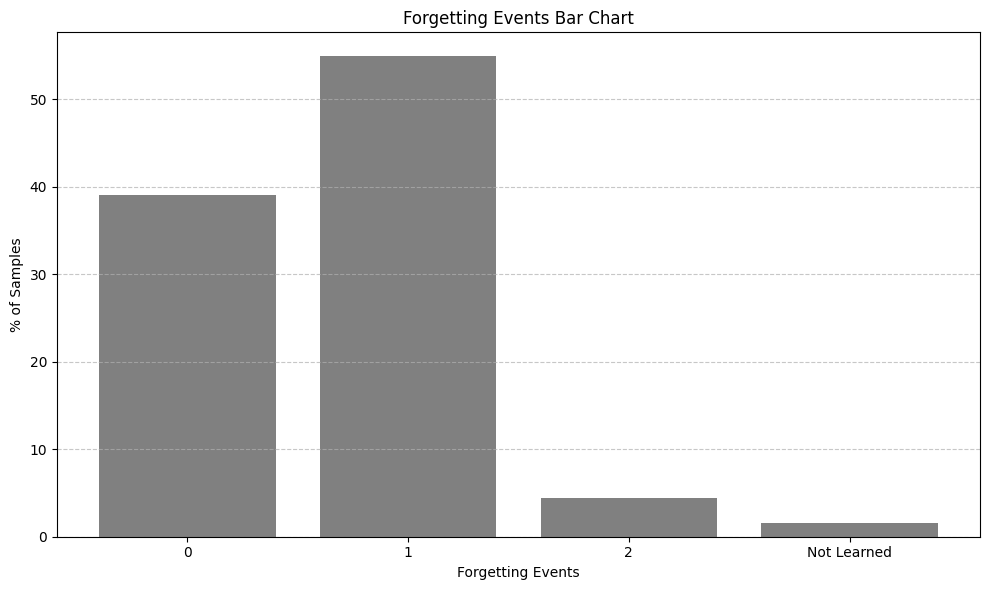

In [ ]:
plt = generate_plots.plot_forgetting_events(forgetting_results=forgetting_results, total_samples=total_samples)
plt.savefig("forgetting_events.png")
wandb.log({"Forgetting Events Chart": wandb.Image("forgetting_events.png")})

plt.tight_layout()
plt.show()

## Losses

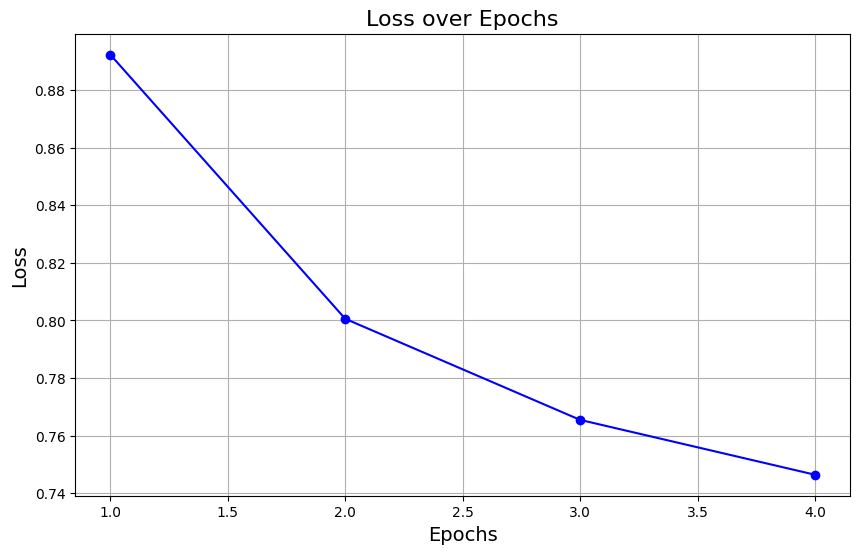

In [ ]:
plt = generate_plots.plot_average_loss_over_epochs(epoch_losses)
plt.savefig("loss_over_epochs.png")
wandb.log({"Loss over Epochs": wandb.Image("loss_over_epochs.png")})
plt.show()

In [ ]:
print(epoch_losses)

[0.8922203728576975, 0.8005745585054784, 0.7654928362895456, 0.7464534327605508]


## Example Groups

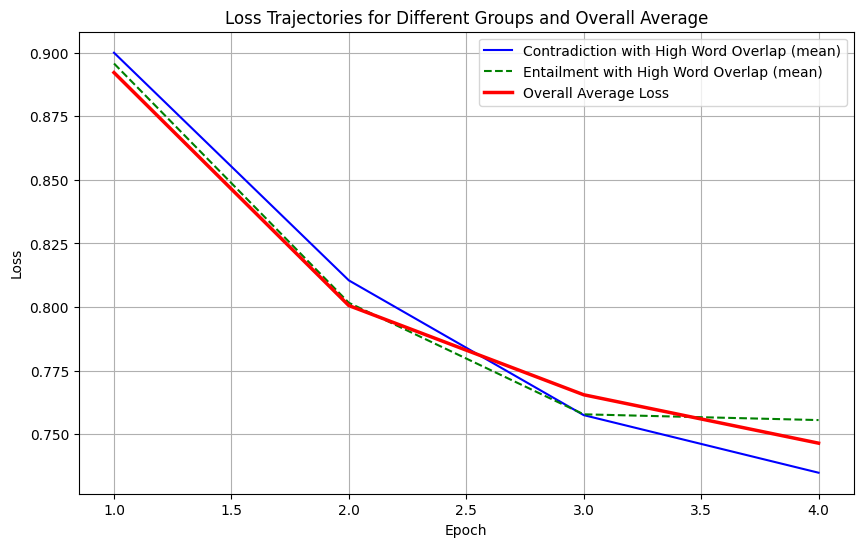

In [ ]:
# Load the MNLI dataset from Hugging Face
mnli = load_dataset('multi_nli')
plt = generate_plots.plot_example_group_losses(mnli, all_losses)
plt.show()

In [ ]:
# Define negation words
negation_words = {"not", "no", "never", "none", "nothing", "nowhere", "neither", "nor",
                  "can't", "won't", "doesn't", "isn't", "aren't", "wasn't", "weren't",
                  "haven't", "hasn't", "hadn't", "wouldn't", "shouldn't", "mustn't"}

# Function to check if a sentence contains negation words
def contains_negation(sentence):
    words = set(sentence.lower().split())
    return any(word in negation_words for word in words)

# Function to compute token-level overlap between hypothesis and premise
def compute_overlap(premise, hypothesis):
    premise_tokens = set(premise.lower().split())
    hypothesis_tokens = hypothesis.lower().split()
    if not hypothesis_tokens:
        return 0
    overlap_ratio = sum(1 for token in hypothesis_tokens if token in premise_tokens) / len(hypothesis_tokens)
    return overlap_ratio

# Initialize counters for train and validation
results = {
    "train": {
        "Contradiction with Negation": 0,
        "Contradiction without Negation": 0,
        "Entailment with High Word Overlap": 0,
        "Entailment with Low Word Overlap": 0,
        "Entailment with Negation": 0,
        "Entailment without Negation": 0,
        "Contradiction with High Word Overlap": 0,
        "Contradiction with Low Word Overlap": 0,
    },
    "validation_matched": {
        "Contradiction with Negation": 0,
        "Contradiction without Negation": 0,
        "Entailment with High Word Overlap": 0,
        "Entailment with Low Word Overlap": 0,
        "Entailment with Negation": 0,
        "Entailment without Negation": 0,
        "Contradiction with High Word Overlap": 0,
        "Contradiction with Low Word Overlap": 0,
    },
}

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset

# Load the MNLI dataset from Hugging Face
mnli = load_dataset('multi_nli')

# Define negation words
negation_words = {"not", "no", "never", "none", "nothing", "nowhere", "neither", "nor",
                  "can't", "won't", "doesn't", "isn't", "aren't", "wasn't", "weren't",
                  "haven't", "hasn't", "hadn't", "wouldn't", "shouldn't", "mustn't"}

# Function to check if a sentence contains negation words
def contains_negation(sentence):
    words = set(sentence.lower().split())
    return any(word in negation_words for word in words)

# Function to compute token-level overlap between hypothesis and premise
def compute_overlap(premise, hypothesis):
    premise_tokens = set(premise.lower().split())
    hypothesis_tokens = hypothesis.lower().split()
    if not hypothesis_tokens:
        return 0
    overlap_ratio = sum(1 for token in hypothesis_tokens if token in premise_tokens) / len(hypothesis_tokens)
    return overlap_ratio

# Initialise data structures to store results
results = {
    "Contradiction with High Word Overlap": [],
    "Entailment with High Word Overlap": [],
}

# Filter indices for each group
for idx, example in enumerate(mnli["train"]):
    premise = example["premise"]
    hypothesis = example["hypothesis"]
    label = example["label"]

    overlap_ratio = compute_overlap(premise, hypothesis)
    high_overlap = overlap_ratio >= 0.8  # Threshold set to 80%

    if label == 2 and high_overlap:  # Contradiction with High Word Overlap
        results["Contradiction with High Word Overlap"].append(idx)
    elif label == 0 and high_overlap:  # Entailment with High Word Overlap
        results["Entailment with High Word Overlap"].append(idx)

[0.44980264 1.71981835 0.10304958 ...        nan        nan        nan]


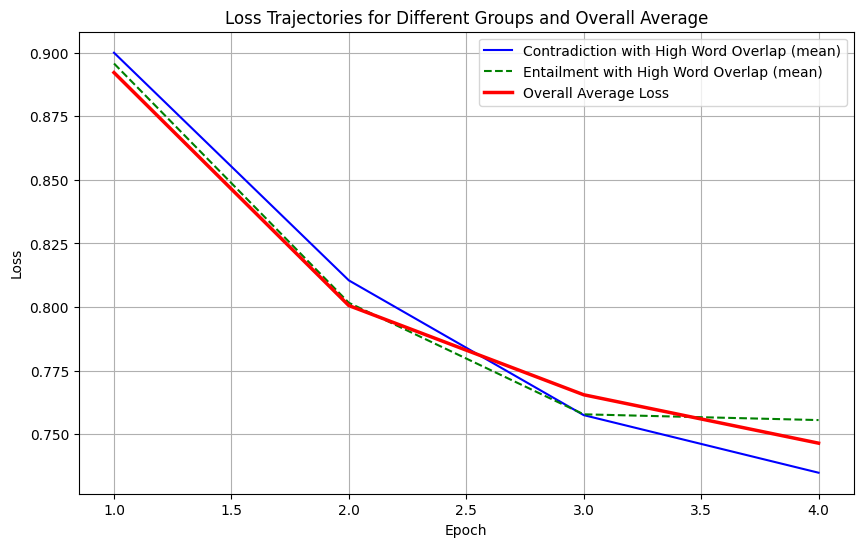

In [ ]:
plt.figure(figsize=(10, 6))
line_styles = ['-', '--', '-.']
colors = ['b', 'g', 'r']

all_losses = np.array(trainer.loss_tracker.losses)

# Plot for each group
for idx, (group, indices) in enumerate(results.items()):
    if not indices:
        print(f"No examples in the group {group}.")
        continue
    
    # Get losses for this group's samples across all epochs
    group_losses = all_losses[:, indices]
    # group_losses[group_losses == 0.0] = np.nan
    avg_loss_per_epoch = np.nanmean(group_losses, axis=1)
    
    # Plot
    plt.plot(range(1, len(avg_loss_per_epoch) + 1), 
             avg_loss_per_epoch,
             label=f"{group} (mean)",
             linestyle=line_styles[idx % len(line_styles)],
             color=colors[idx % len(colors)])

# Plot overall average
overall_avg_per_epoch = np.nanmean(all_losses, axis=1)
print(all_losses[1])
plt.plot(range(1, len(overall_avg_per_epoch) + 1),
         overall_avg_per_epoch,
         label='Overall Average Loss',
         linestyle='-',
         color=colors[-1],
         linewidth=2.5)

plt.title("Loss Trajectories for Different Groups and Overall Average")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.savefig("group_loss_trajectories.png")
wandb.log({"Loss Trajectories for High Word Overlap Groups": wandb.Image("group_loss_trajectories.png")})

<Figure size 640x480 with 0 Axes>

## Data Maps

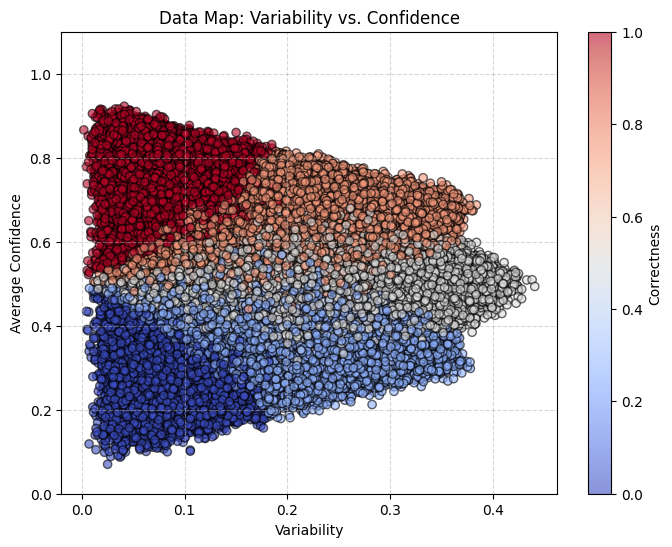

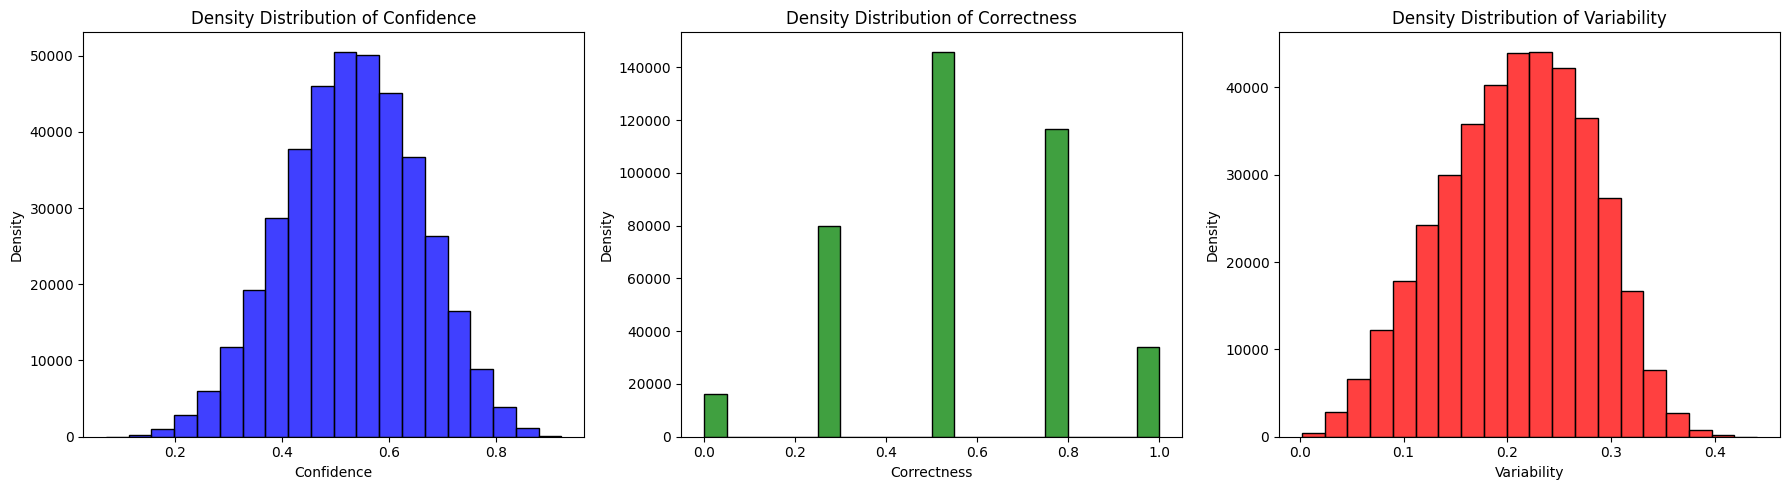

In [ ]:
fig1, fig2 = generate_plots.plot_data_map(data_map_stats)
fig1.show()
fig2.show()

## AUM

In [ ]:
print(len(aum_scores))

4


## Finishing Up

In [ ]:
wandb.log({
    "epoch_losses": epoch_losses,
    "per_sample_losses": per_sample_losses,
    "final_forgetting_stats": forgetting_results,
})

In [ ]:
wandb.finish()

eval/accuracy,▁▅██
eval/loss,█▄▁▁
eval/runtime,▂▁▂█
eval/samples_per_second,▇█▇▁
eval/steps_per_second,▇█▇▁
train/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇███████
train/grad_norm,▁▄▄▅▆▅▅▅▅▅▅▅▄▄▄▅█▆▆▅▆▄▆▅▆▅▄▅▆▇▅▆▅
train/learning_rate,███▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
train/loss,█▆▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/accuracy,0.67927
